In [2]:
import numpy as np 
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("photos_reduced"))

FAST_RUN = False
IMAGE_WIDTH=125
IMAGE_HEIGHT=125
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


['Zwiebel_reduced', 'Kartoffel_reduced', 'Karotte_reduced']


In [3]:
# Pfade zu den Ordnern
folder_potato = 'photos_reduced/Kartoffel_reduced'
folder_onion = 'photos_reduced/Zwiebel_reduced'
folder_carrot = 'photos_reduced/Karotte_reduced'

# Initialisierung der Listen
categories = []
filenames = []

# Durchlaufen des Kartoffel-Ordners
for filename in os.listdir(folder_potato):
    categories.append(0)  # Kartoffel-Kategorie
    filenames.append(os.path.join(folder_potato, filename))

# Durchlaufen des Zwiebel-Ordners
for filename in os.listdir(folder_onion):
    categories.append(1)  # Zwiebel-Kategorie
    filenames.append(os.path.join(folder_onion, filename))

# Durchlaufen des Karotte-Ordners
for filename in os.listdir(folder_carrot):
    categories.append(2)  # Karotte-Kategorie
    filenames.append(os.path.join(folder_carrot, filename))

# Erstellung des DataFrames
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

# Ausgabe der ersten 5 Einträge des Dataframes
df.head()


,filename,category
0,photos_reduced/Kartoffel_reduced/Kartoffel (11...,0
1,photos_reduced/Kartoffel_reduced/Kartoffel (82...,0
2,photos_reduced/Kartoffel_reduced/Kartoffel (48...,0
3,photos_reduced/Kartoffel_reduced/Kartoffel (70...,0
4,photos_reduced/Kartoffel_reduced/Kartoffel (13...,0


<AxesSubplot:xlabel='category'>

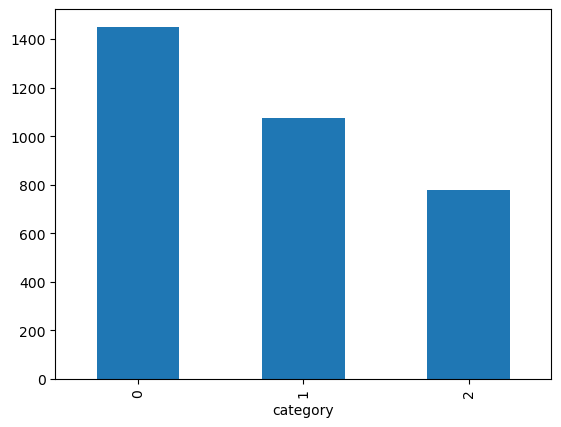

In [4]:
# Anzeigen der Gesamtzahl der Bilder in den Kategorien 
df['category'].value_counts().plot.bar()


In [5]:
# Ersetzen der Integer Werte für die Klasse durch einen String 
df["category"] = df["category"].replace({0: 'potato', 1: 'onion', 2: 'carrot'}) 

# Teilen der Daten in Traingsdaten und Validierungsdaten
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 32

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.optimizers import RMSprop

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
#model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # 3 Klassen (Kartoffel, Zwiebel, Karotte)

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

#model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=0.0001), metrics=['accuracy'])

#model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.0001), metrics=['accuracy'])



model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 123, 123, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 123, 123, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 61, 61, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 61, 61, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 59, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 59, 59, 64)        2

In [7]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [8]:
earlystop = EarlyStopping(patience=2)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
                                            
callbacks = [earlystop, learning_rate_reduction]

In [9]:
# Anwenden von Data Augmentation

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    #zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [10]:
# laden der Bilder in den Datengenerator
train_generator = train_datagen.flow_from_dataframe(
    train_df,  
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 2645 validated image filenames belonging to 3 classes.


In [11]:
# Normieren der Bilder für die Validation 
validation_datagen = ImageDataGenerator(rescale=1./255)
# laden der Bilder in den Datengenerator
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 662 validated image filenames belonging to 3 classes.


Found 1 validated image filenames belonging to 1 classes.


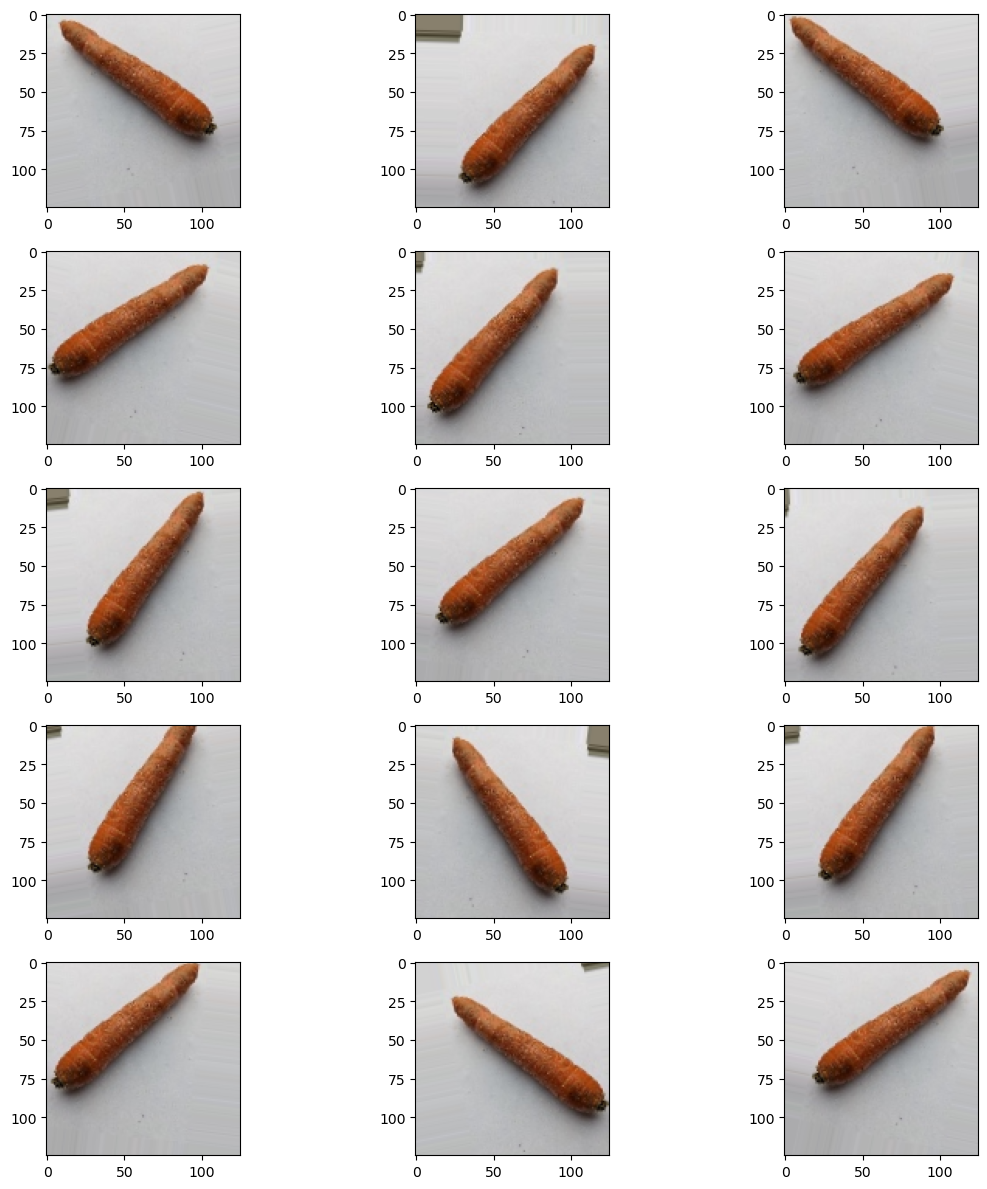

In [12]:
# Anzeigen der Bilder nach der Data Augmentation 
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)


plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [13]:
# Modelltraining

# epochs = 5
# history = model.fit(
#     train_generator, 
#     epochs=epochs,
#     validation_data=validation_generator,
#     validation_steps=total_validate // batch_size,
#     callbacks=callbacks
# )


epochs = 50
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate // batch_size,
    steps_per_epoch=total_train // batch_size,
    callbacks=callbacks
)


Epoch 1/50
82/82 [==============================] - 34s 407ms/step - loss: 1.0822 - accuracy: 0.6869 - val_loss: 9.0801 - val_accuracy: 0.3156 - lr: 0.0010
Epoch 2/50
82/82 [==============================] - 32s 387ms/step - loss: 0.4460 - accuracy: 0.8274 - val_loss: 2.1604 - val_accuracy: 0.3234 - lr: 0.0010
Epoch 3/50
82/82 [==============================] - 32s 394ms/step - loss: 0.3190 - accuracy: 0.8695 - val_loss: 3.2377 - val_accuracy: 0.4922 - lr: 0.0010
Epoch 4/50
82/82 [==============================] - 33s 403ms/step - loss: 0.2357 - accuracy: 0.9120 - val_loss: 1.5391 - val_accuracy: 0.5781 - lr: 0.0010
Epoch 5/50
82/82 [==============================] - 31s 379ms/step - loss: 0.2411 - accuracy: 0.9024 - val_loss: 2.2909 - val_accuracy: 0.5250 - lr: 0.0010
Epoch 6/50
82/82 [==============================] - 31s 381ms/step - loss: 0.1948 - accuracy: 0.9231 - val_loss: 0.6420 - val_accuracy: 0.7797 - lr: 0.0010
Epoch 7/50
82/82 [==============================] - 32s 386ms/st

In [14]:
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


21/21 [==============================] - 2s 79ms/step - loss: 0.5161 - accuracy: 0.7900
Test Loss: 0.5161294937133789
Test Accuracy: 0.7900302410125732


In [15]:
predictions = model.predict(validation_generator)


21/21 [==============================] - 2s 75ms/step


1/1 [==============================] - 0s 128ms/step


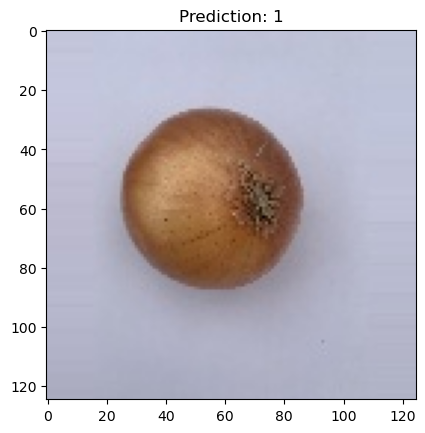

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint

# Zufälliges Bild auswählen
index = randint(0, len(validation_generator.filepaths) - 1)
image_path = validation_generator.filepaths[index]

# Bild laden und vorhersagen
img = plt.imread(image_path)
img_array = np.expand_dims(img, axis=0)
prediction = model.predict(img_array)

# Vorhersagen visualisieren
plt.imshow(img)
plt.title(f'Prediction: {prediction.argmax()}')
plt.show()

#0: Kartoffel
#1: Zwiebel
#2: Karotte


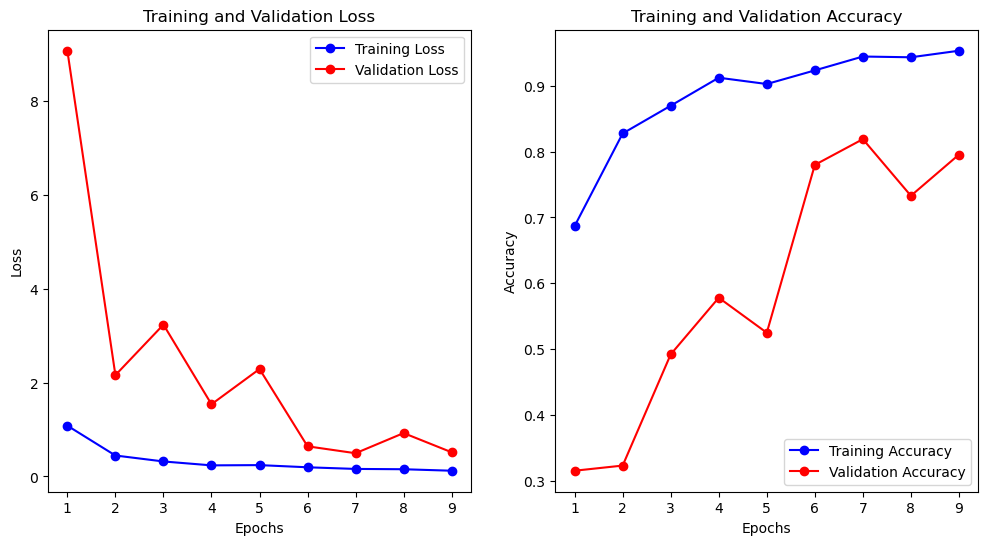

In [17]:
import matplotlib.pyplot as plt

# Trainings- und Validierungsloss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Trainings- und Validierungsgenauigkeit
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Anzahl der Epochen
epochs = range(1, len(train_loss) + 1)

# Loss-Plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy-Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [18]:
model.save('vegetable.h5')

/home/michelle/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 21ms/step


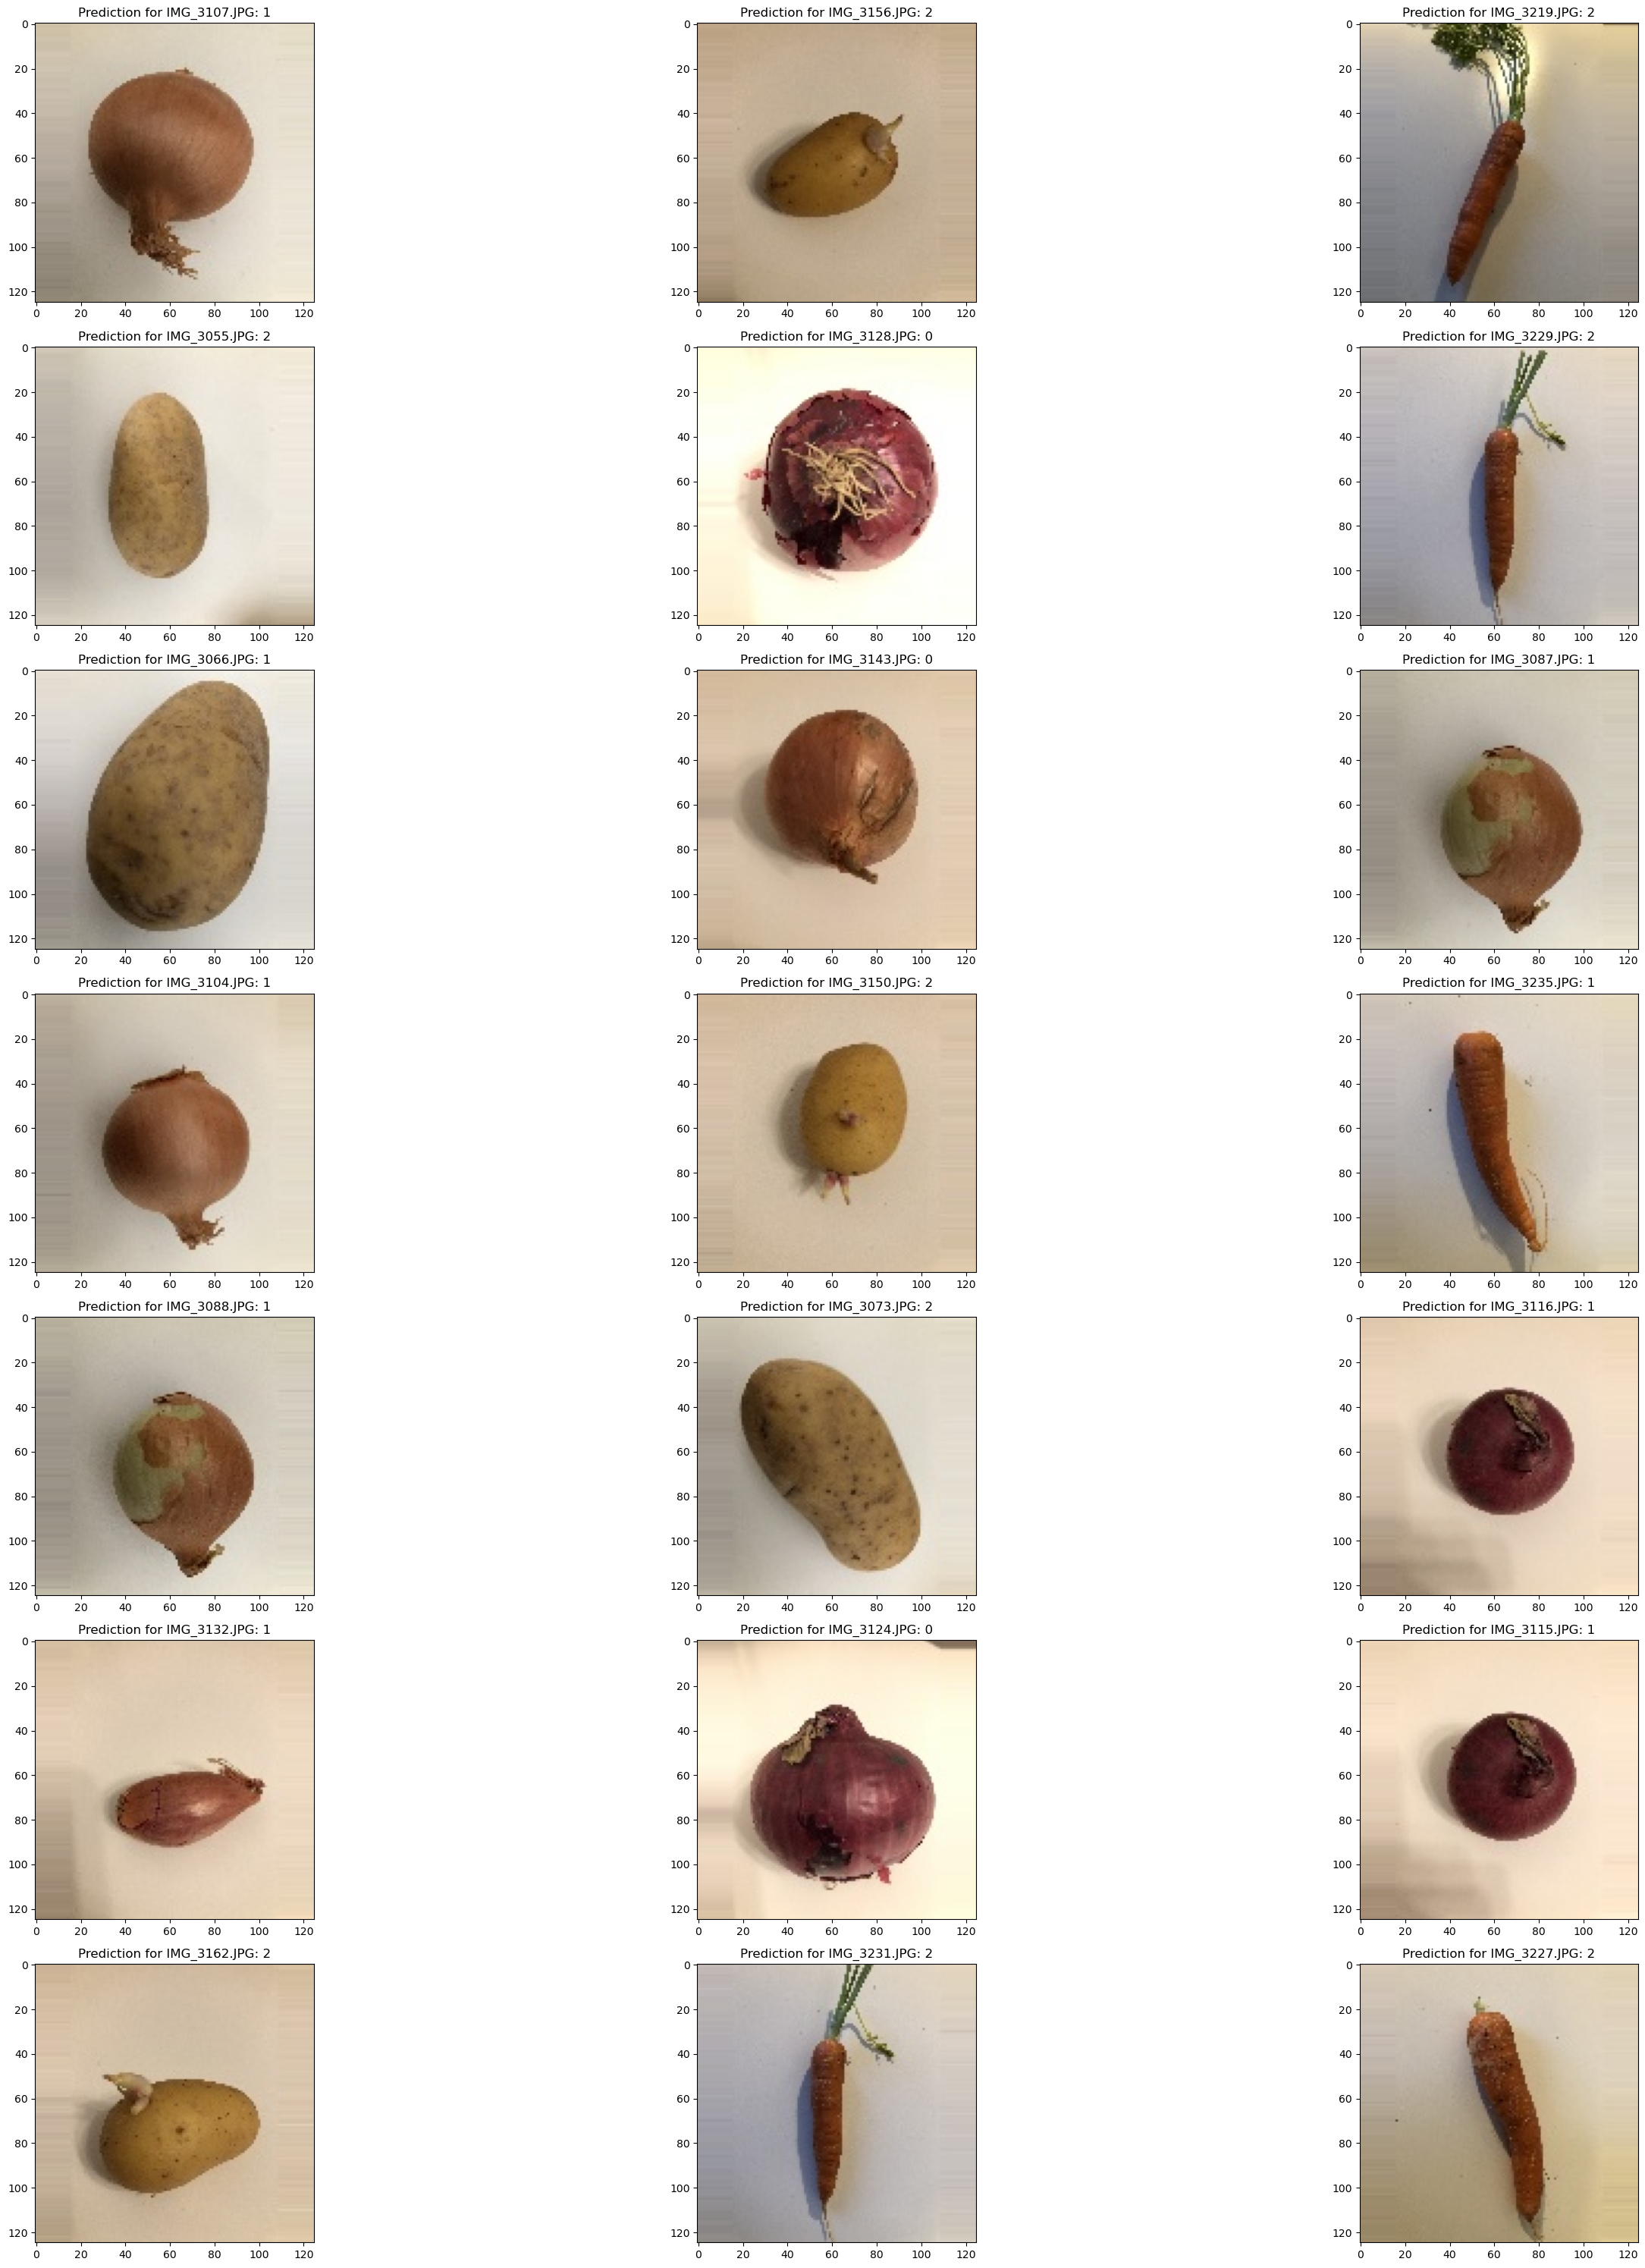

In [19]:
import os
from keras.models import load_model

# Pfad zum Ordner mit den Bildern
folder_path = 'KI_Bilder_Burkhardt_reduced_gemischt'

# Anzahl der Bilder pro Reihe
images_per_row = 3

# Größe der gesamten Abbildung anpassen
plt.figure(figsize=(30, 30))  # Hier kannst du die Größe nach Bedarf anpassen

# Laden des Modells mit den trainierten Gewichten
model = load_model(r'vegetable.h5')


# Iteriere durch alle Bilder im Ordner
for i, filename in enumerate(os.listdir(folder_path), 1): 
    image_path = os.path.join(folder_path, filename)

    # Bild laden und vorhersagen
    img = plt.imread(image_path)
    img_array = np.expand_dims(img, axis=0)
    prediction = model.predict(img_array)

    # Subplot erstellen
    plt.subplot((len(os.listdir(folder_path)) + images_per_row - 1) // images_per_row, images_per_row, i)
    
    # Vorhersagen visualisieren
    plt.imshow(img)
    plt.title(f'Prediction for {filename}: {prediction.argmax()}')

# Layout verbessern
plt.tight_layout()
plt.show()

#0: Kartoffel
#1: Zwiebel
#2: Karotte
